In [2]:
%cd ..

/home/amir/projects/frame_stack


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
signals = torch.rand(1, 4, 64)

In [4]:

from torchvision.transforms.functional import rotate as torch_rotate
from torchvision.transforms import InterpolationMode
import numpy as np

In [5]:
image = signals.unsqueeze(-2).repeat(1, 1, 64, 1)
image.shape

torch.Size([1, 4, 64, 64])

In [ ]:
for i in range(image.shape[-3]):
    image[:, i] = torch_rotate()

In [ ]:
pressure = torch.from_numpy(np.load('data/video/pressure/34/2/prepared.npz')['arr_0'][200:201])
signal = torch.from_numpy(np.load('data/video/train_signal/34/2/prepared.npz')['arr_0'][200:201])

In [7]:
import matplotlib.pyplot as plt

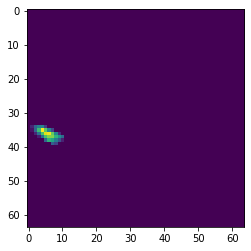

In [23]:
plt.imshow(pressure[0])

In [26]:
image = signal.unsqueeze(-2).repeat(1, 1, 64, 1)
image.shape
for i in range(image.shape[-3]):
    image[:, i] = torch_rotate(image[:, i], -180/4*i, interpolation=InterpolationMode.BILINEAR)

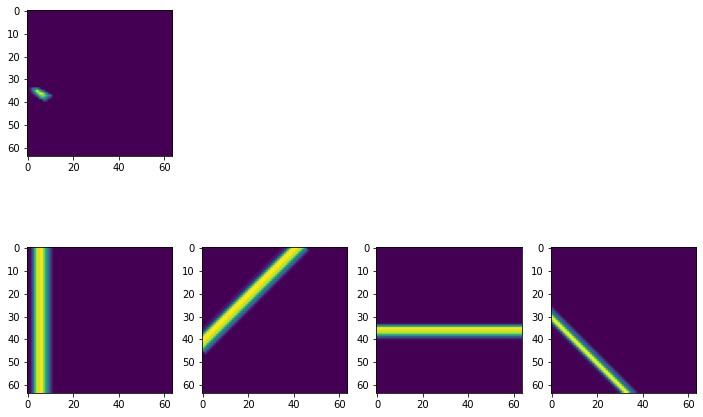

In [27]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(2, 4, 1)
plt.imshow(pressure[0])
for i in range(4):
    plt.subplot(2, 4, 5+i)
    plt.imshow(image[0, i])
# plt.subplot(2, 4, 6)
# plt.imshow(image[0, ])
# plt.subplot(2, 4, 7)
# plt.imshow(image[0, ])
# plt.subplot(2, 4, 8)
# plt.imshow(image[0, ])


In [5]:
import h5py 
import hdf5plugin

file = h5py.File('data/video/signal/train/train_videos.hdf5', 'r')
test_signal = np.concatenate([file[next(iter(file.keys()))][:], file[next(iter(file.keys()))][:], file[next(iter(file.keys()))][:]])

In [6]:
test_signal.shape

(900, 4, 64)

In [7]:

class Unet2(nn.Module):
      
    def __init__(self, output_shape, input_shape, frames_number, frames_interval):
        assert frames_number == 1
        input_shape = input_shape[-2:]
        self.output_shape = output_shape[-2:]
        super(Unet2, self).__init__()

        self.frames_interval, self.frames_number = frames_interval, frames_number 
        
        self.step1 = nn.Sequential(nn.Conv2d(input_shape[-2], 16, (3, 3), 1, 'same'),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 16, (3, 3), 1, 'same'),
                                   nn.ReLU(),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 16, (3, 3), 1, 'same'),
                                   nn.ReLU(),
                                   )
        self.finalConv = nn.Sequential(
                                   nn.Conv2d(32, 16, (3, 3), 1, 'same'),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 16, (3, 3), 1, 'same'),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 1, 1, padding='same'))
        def UnetBlocks(down_in_ch, down_out_ch, down_conv_n, up_in_ch, up_inner_ch, up_out_ch, up_conv_n):
            down_layers = [nn.Conv2d(down_in_ch, down_out_ch, (3, 3), 2, 1),
                                    nn.ReLU(),]
            for i in range(down_conv_n):
                down_layers.extend([nn.Conv2d(down_out_ch, down_out_ch, (3, 3), 1, 'same'),
                                    nn.ReLU()])
            down = nn.Sequential(*down_layers)
            
            
            up_layers = [nn.Conv2d(up_in_ch, up_inner_ch, (3, 3), 1, 'same'),
                                    nn.ReLU(),]
            for i in range(down_conv_n-1):
                up_layers.extend([nn.Conv2d(up_inner_ch, up_inner_ch, (3, 3), 1, 'same'),
                                    nn.ReLU()])
            up_layers.extend([nn.ConvTranspose2d(up_inner_ch, up_out_ch, (2, 2), 2, 0),
                                   nn.ReLU(),])
            up = nn.Sequential(*up_layers)
            return down, up
        
        self.down1, self.up1 = UnetBlocks(16, 16, 3, 32, 32, 16, 3)
        self.down2, self.up2 = UnetBlocks(16, 32, 3, 64, 32, 16, 3)
        self.down3, self.up3 = UnetBlocks(32, 64, 3, 128, 64, 32, 3)
        self.down4, self.up4 = UnetBlocks(64, 64, 3, 64, 64, 64, 3)
        
           
    def forward(self, x):
        
        x = torch.swapaxes(x, -2, -3).repeat(1, 1, 64, 1)
        for i in range(x.shape[-3]):
            x[:, i] = torch_rotate(x[:, i], -180/x.shape[-3]*i, interpolation=InterpolationMode.BILINEAR)
            
        res0 = self.step1(x)
        res1 = self.down1(res0)
        
        res2 = self.down2(res1)
        
        res3 = self.down3(res2)
        
        x = self.down4(res3)
        x = self.up4(x)
        
        x = torch.concat([x, res3], -3)
        x = self.up3(x)
        
        x = torch.concat([x, res2], -3)
        
        x = self.up2(x)
        
        x = torch.concat([x, res1], -3)
        
        x = self.up1(x)
        
        x = torch.concat([x, res0], -3)
        
        x = self.finalConv(x)
        x = x.squeeze(-3)
        
        # x = x.view(-1, *self.output_shape)
        return x
            
            
        
 
model = Unet2((64, 64), (4, 64), 1, 1)

In [8]:
device = 'cuda'

In [9]:
model = model.to(device)
x = torch.tensor(test_signal, device=device).unsqueeze(-3)

In [10]:
%%timeit
model(x)

121 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
model(x).shape

torch.Size([900, 64, 64])

In [12]:
%%timeit
model(x[:1])

19.7 ms ± 603 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
y = x

In [ ]:
%%timeit
x = y
x = torch.swapaxes(x, -2, -3).repeat(1, 1, 64, 1)
for i in range(x.shape[-3]):
    x[:, i] = torch_rotate(x[:, i], -180/x.shape[-3]*i, interpolation=InterpolationMode.BILINEAR)
    

In [ ]:
%%timeit
x = y[:10]
x = torch.swapaxes(x, -2, -3).repeat(1, 1, 64, 1)
for i in range(x.shape[-3]):
    x[:, i] = torch_rotate(x[:, i], -180/x.shape[-3]*i, interpolation=InterpolationMode.BILINEAR)
    

12.3 ms ± 568 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
x = y
x = torch.swapaxes(x, -2, -3).repeat(1, 1, 64, 1)
for i in range(x.shape[-3]):
    x[:, i] = torch_rotate(x[:, i], -180/x.shape[-3]*i, interpolation=InterpolationMode.BILINEAR)
    

In [17]:
%%timeit
res0 = model.step1(x)
res1 = model.down1(res0)

res2 = model.down2(res1)

res3 = model.down3(res2)

40.4 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit
res0 = model.step1(x)

23 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%%timeit
res0 = model.step1(x)
res1 = model.down1(res0)


33.8 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%timeit
x = model.down4(res3)
x = model.up4(x)
        

2.72 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
x = y
x = torch.swapaxes(x, -2, -3).repeat(1, 1, 64, 1)
for i in range(x.shape[-3]):
    x[:, i] = torch_rotate(x[:, i], -180/x.shape[-3]*i, interpolation=InterpolationMode.BILINEAR)

res0 = model.step1(x)
res1 = model.down1(res0)

res2 = model.down2(res1)

res3 = model.down3(res2)
x = model.down4(res3)
x = model.up4(x)
t = x

In [28]:
%%timeit
x = t
x = torch.concat([x, res3], -3)
x = model.up3(x)

x = torch.concat([x, res2], -3)

x = model.up2(x)

x = torch.concat([x, res1], -3)

x = model.up1(x)

x = torch.concat([x, res0], -3)

x = model.finalConv(x)

59.2 ms ± 92.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%%timeit
x = t
x = torch.concat([x, res3], -3)
x = model.up3(x)

x = torch.concat([x, res2], -3)

x = model.up2(x)

x = torch.concat([x, res1], -3)

x = model.up1(x)

x = torch.concat([x, res0], -3)

34.5 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
device='cuda'

In [72]:

class ParamUnet(nn.Module):
      
    def __init__(self, output_shape, input_shape, channels, frames_number, frames_interval):
        assert frames_number == 1
        input_shape = input_shape[-2:]
        self.output_shape = output_shape[-2:]
        super(ParamUnet, self).__init__()

        self.frames_interval, self.frames_number = frames_interval, frames_number 
        
        self.step1 = nn.Sequential(nn.Conv2d(input_shape[-2], channels[0], (3, 3), 1, 'same'),
                                   nn.ReLU(),
                                   nn.Conv2d(channels[0], channels[0], (3, 3), 1, 'same'),
                                   nn.ReLU(),
                                   nn.Conv2d(channels[0], channels[0], (3, 3), 1, 'same'),
                                   nn.ReLU(),
                                   )
        self.finalConv = nn.Sequential(
                                   nn.Conv2d(channels[0]+channels[-1], channels[-1], (3, 3), 1, 'same'),
                                   nn.ReLU(),
                                   nn.Conv2d(channels[-1], channels[-1], (3, 3), 1, 'same'),
                                   nn.ReLU(),
                                   nn.Conv2d(channels[-1], 1, 1, padding='same'))
        def UnetBlocks(down_in_ch, down_out_ch, down_conv_n, up_in_ch, up_inner_ch, up_out_ch, up_conv_n):
            down_layers = [nn.Conv2d(down_in_ch, down_out_ch, (3, 3), 2, 1),
                                    nn.ReLU(),]
            for i in range(down_conv_n):
                down_layers.extend([nn.Conv2d(down_out_ch, down_out_ch, (3, 3), 1, 'same'),
                                    nn.ReLU()])
            down = nn.Sequential(*down_layers)
            up_layers = [nn.Conv2d(up_in_ch, up_inner_ch, (3, 3), 1, 'same'),
                                    nn.ReLU(),]
            for i in range(up_conv_n-1):
                up_layers.extend([nn.Conv2d(up_inner_ch, up_inner_ch, (3, 3), 1, 'same'),
                                    nn.ReLU()])
            up_layers.extend([nn.ConvTranspose2d(up_inner_ch, up_out_ch, (2, 2), 2, 0),
                                   nn.ReLU(),])
            up = nn.Sequential(*up_layers)
            return down, up
        
        self.down_list = [self.step1]
        self.up_list = []
        for i in range(len(channels)//2-2):
            down, up = UnetBlocks(channels[i], channels[i+1], 3, channels[i+1] + channels[-i-2], channels[-i-2], channels[-i-1], 3)
            self.down_list.append(down), self.up_list.append(up)
        i = len(channels)//2-2
        down, up = UnetBlocks(channels[i], channels[i+1], 2, channels[-i-2], channels[-i-2], channels[-i-1], 2)
        self.down_list.append(down), self.up_list.append(up)
        
        self.up_list = self.up_list[::-1] + [self.finalConv]

        self.bottom = nn.Sequential(*self.down_list, *self.up_list)
        
    def forward(self, x):
        
        x = torch.swapaxes(x, -2, -3).repeat(1, 1, 64, 1)
        for i in range(x.shape[-3]):
            x[:, i] = torch_rotate(x[:, i], -180/x.shape[-3]*i, interpolation=InterpolationMode.BILINEAR)
        
        res = []
        for i in range(len(self.down_list)-1):
            x = self.down_list[i](x)
            res.append(x)
        x = self.down_list[-1](x)
        x = self.up_list[0](x)

        for i in range(len(self.up_list)-1):
            x = torch.concat([x, res[-i-1]], -3)
            x = self.up_list[i+1](x)
            
        x = x.squeeze(-3)
        
        # x = x.view(-1, *self.output_shape)
        return x
p_model = ParamUnet((64, 64), (4, 64), [16, 32, 64, 128, 128, 64, 32, 16], 1, 1).to(device)

In [67]:
x = torch.tensor(test_signal, device=device).unsqueeze(-3)

In [73]:
%%timeit
p_model(x);

148 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
p_model = ParamUnet((64, 64), (4, 64), [8, 16, 32, 64, 64, 32, 16, 8], 1, 1).to(device)

In [ ]:
%%timeit
p_model(x);

84.5 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
